In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

What is the input? What is the output? What data mining function is required? What could be the challenges? What is the impact? What is an ideal solution?<br>
Input: profile of the two people in a matching date<br>
output: 1 for success date and 0 for unsuccessful date<br>
Chanlenge:Find the most suitable model and parameter for the prediction task. It's really hard for the test score to break through 0.9.<br>
Impact: Multiple parameter tuning has to be done to find the best setting, which increases the training time greatly from a few minutes to a few 10 minutes.<br>
Ideal Solution: The model should predict profiles of every successfully matched couple as a 1 and unsuccessfulk ones should be predicted 0. The means, every couple that predicted a 1 should be able to have a good time with each other; for the couples predicted a 0, wish they better luck next time. 


Q:What is the experimental protocol used and how was it carried out? What preprocessing steps are used? <br>
A:The purporse of the experiment is to predict whether the date will be successful given the profile of two people.<br>
The materials are pre-splitted datasets train_new.csv and test_new.csv. The evironment is google colab notebook. <br>
Methodology:<br>
Grid search,Random search and Bayesian search models are used to analyze and evaluate the data.<br>
First, do some preprocessing with the original data(done in the walkthrough notebook). The numerical categorical data processing is done through the pipeline.<br>
Then, use the default setting (already done in the notebook)without any parameter tuning or extra data preprocessing in the walkthrough notebook to set up the model. Train the model with untuned training data and generate validation score using validation data.<br>
After that, tune the hyperparameter or do extra data preprocessing and repeat the process and see if there is improvements in validation score. For each of the three models, 2 parameter tunes are done.<br>
<br>

In [ ]:
#Extract data from the csv files
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data.shape

(5909, 192)

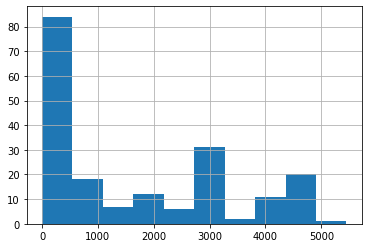

In [ ]:
data.isnull().sum().hist()
#numerous null data blocks

In [ ]:
# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#split the features and labels
x = data.drop('match', axis=1)
#split the numeric features and categorical data
features_numeric = list(x.select_dtypes(include=['float64']))
features_categorical = list(x.select_dtypes(include=['object']))
#get the labels
y = data['match']


In [ ]:
#print the categorical feature names
print(features_categorical)

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


Now based on the template, try to improve the model's performance on the public leaderboard by following the data science life-cycle for tuning. You can try different features, different hyperparameters/configurations of the model, and even a different model. For each trial, document the reason why you want to make the certain change and the expected outcome, before running the code. Record the observed performance and your thought on it. The final result is not important, but the process is. Documentation of your thought process is very important, since most people forgot why they test certain model/hyperparameter after they got the result (it takes time). It also helps a lot when you got stuck. You can organize the notebook by listing

thoughts and observations for trial 0, plan for trial 1
code for trial 1
thoughts and observations for trial 1, plan for trial 2
code for trial 2
…
You have to tune at least 6 times. All the tried solutions should be different (e.g. different feature sets/different preprocessing/model/tuning method/tuning range). Requirements - covered at least:

one grid search trial,
and one random search trial,
and one bayesian search trial

In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0)
#deal with the numeric vlaues
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),#replace the missing value with the median value in this feature
        ('scaler', StandardScaler())]
)
#deal with the categorical values
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),#fill the missing value with 'missing' and then replace the label with a constant numeric value
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
#combine the two pipeline above together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)
#final pipeline
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))#It is a binary classification problem
    ]
)






In [ ]:
#Example run of gridsearch
# `__` denotes attribute 
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score 0.8789401909943632
best score {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
#trial 1
#increase the number of choices for the parameters and see if it reaches the best selection of these parameters
#increase depth and estimator number
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [20, 100, 200],
    'my_classifier__max_depth':[30,40]}
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
# the result had slight increase as the depth and estimators increase
#but the running time increases from 2 mins to 6 mins

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score 0.8808741520245137
best score {'my_classifier__max_depth': 40, 'my_classifier__n_estimators': 200, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
#trial 2
#the increase in accuracy is too little to measure for the last trial
#to improve efficiency, let's try multiple learning rate setting, lower maximum depth and try to tweak the loss function
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [50,80,100],
    'my_classifier__max_depth':[2,3,5],
    'my_classifier__learning_rate':[0.05,0.1,0.2],#learning rate
    'my_classifier__reg_alpha':[2,5,8],#loss function
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
#more increase in scores

Fitting 5 folds for each of 81 candidates, totalling 405 fits
best score 0.8821970573122855
best score {'my_classifier__learning_rate': 0.1, 'my_classifier__max_depth': 5, 'my_classifier__n_estimators': 80, 'my_classifier__reg_alpha': 2, 'preprocessor__num__imputer__strategy': 'mean'}


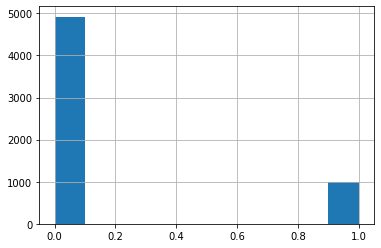

In [ ]:
data['match'].hist()
#match score is binary

In [ ]:
#trial 3
#As seen in the diagram aove, the positive sample (1) is significantly lower than that of negative samples(0)
#Thus the scale_pos_weight attribute may need to be adjusted
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [100],
    'my_classifier__max_depth':[3],
    'my_classifier__learning_rate':[0.1],#learning rate
    'my_classifier__reg_alpha':[5],#loss function
    'my_classifier__scale_pos_weight':[0.2,0.4,0.6,1,2,3,4,5]#the pos/neg sample ratio
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
#no change in scores since the scale is the best as default

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score 0.8768925286826104
best score {'my_classifier__learning_rate': 0.1, 'my_classifier__max_depth': 3, 'my_classifier__n_estimators': 100, 'my_classifier__reg_alpha': 5, 'my_classifier__scale_pos_weight': 4, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
#random search trial 1
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [50,80,100],
    'my_classifier__max_depth':[2,3,5],
    'my_classifier__learning_rate':[0.1],#learning rate
    'my_classifier__reg_alpha':[2,5,8]#loss function
}
#nearly the same layout as gridsearch
random_search = RandomizedSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

random_search.fit(x, y)
print('best score {}'.format(random_search.best_score_))
print('best score {}'.format(random_search.best_params_))
#not much difference with the grid search trial

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best score 0.8817523075219587
best score {'preprocessor__num__imputer__strategy': 'mean', 'my_classifier__reg_alpha': 2, 'my_classifier__n_estimators': 100, 'my_classifier__max_depth': 5, 'my_classifier__learning_rate': 0.1}


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_svc', SVC(class_weight='balanced'))
    ]
)
# SVC has a class_weight attribute for unbalanced data


# define ranges for bayes search
bayes_search = BayesSearchCV(
    SVC_pipline,
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'my_svc__degree': Integer(1,8),
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']),
    },
    n_iter=3,
    random_state=0,
    verbose=3,
)

bayes_search.fit(x, y)
print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.830 total time=  11.3s
[CV 2/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.812 total time=   9.7s
[CV 3/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.818 total time=  10.0s
[CV 4/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.821 total time=  14.0s
[CV 5/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.832 total time=  11.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly;, score=0.838 total 

In [ ]:
#trial 1 bayes search
#since the polynomial kernel is the best fit, the best coefficient needed to be adjusted for the model
#Increase in degree might improve the result too
bayes_search = BayesSearchCV(
    SVC_pipline,
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'),#regularization parameter
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'),#kernel coefficient
        'my_svc__degree': Integer(8,16),#degree of polynomial
        'my_svc__kernel': Categorical([ 'poly']),#kernel category
        'my_svc__coef0': Real(0,1) #polynomial coefficient
    },
    n_iter=3,
    random_state=0,
    verbose=3,
)

bayes_search.fit(x, y)
print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))
#improves in the scores

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.840 total time=   9.5s
[CV 2/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.821 total time=   9.6s
[CV 3/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.825 total time=  12.8s
[CV 4/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.831 total time=  12.8s
[CV 5/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.829 total time=  12.8s
Fitting 5 folds for e

In [ ]:
#trial 2 bayes search
#Increasing the number of iterations and lets see if the score improves
bayes_search = BayesSearchCV(
    SVC_pipline,
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'my_svc__degree': Integer(8,16),
        'my_svc__kernel': Categorical([ 'poly']),
        'my_svc__coef0': Real(0,1)
    },
    n_iter=6,#iterations increases may lead to increase in score if underfitting as bayesian search learns from previous iterations
    random_state=0,
    verbose=3,
)

bayes_search.fit(x, y)
print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))
#slightly improves the scores,not much is done
#it could be considerred that the model is already fitting itself

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.840 total time=   9.3s
[CV 2/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.821 total time=   9.5s
[CV 3/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.825 total time=  12.9s
[CV 4/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.831 total time=  11.3s
[CV 5/5] END my_svc__C=2.352718564818733, my_svc__coef0=0.6760795088769136, my_svc__degree=13, my_svc__gamma=0.033632533813774734, my_svc__kernel=poly;, score=0.829 total time=  12.8s
Fitting 5 folds for e

As a result ,we select the result from gridsearch in the second trial and prepare our submission.

In [ ]:
# print('all the cv scores')
# pprint(bayes_search.cv_results_)

In [ ]:
#Final submission
#the increase in accuracy is too little to measure for the last trial
#to improve efficiency, let's try multiple learning rate setting, lower maximum depth and try to tweak the loss function
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [80],
    'my_classifier__max_depth':[5],
    'my_classifier__learning_rate':[0.1],#learning rate
    'my_classifier__reg_alpha':[2],#loss function
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
#slight increase in scores

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best score 0.8821970573122855
best score {'my_classifier__learning_rate': 0.1, 'my_classifier__max_depth': 5, 'my_classifier__n_estimators': 80, 'my_classifier__reg_alpha': 2, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
#prepare submission:
submission = pd.DataFrame()
submission['id'] = data_test['id']
submission['match'] = grid_search.predict_proba(data_test)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)
submission

,id,match
0,934,0.079463
1,6539,0.481633
2,6757,0.261872
3,2275,0.059485
4,1052,0.042743
...,...,...
2464,7982,0.202070
2465,7299,0.341643
2466,1818,0.090478
2467,937,0.030958


Q:🌈Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?<br>
A: Because simple linear regression model deals with coninuous values whereas in a classification task, discrete values are handled. Perceptron deals with binary class label which are discrete values.<br>
🌈What's a decision tree and how it is different to a logistic regression model?<br>
A：Decsion tree performs like a flow chart and evey node on it tests the result from pervious node. After the test, the result is shown by the node extending branches to other node. Compare to logistic regression model, decision tree doesn't aim to divide the data points into two or three catergories but to divide them up to a number of small blocks by coninously splitting them.<br>
🌈What's the difference between grid search and random search?<br>
A: Random search searches the datapoints/nodes randomly in batches, that means not all datapoints are evualuated in one iteration. Grid search has certain order to loop through all the datapoints.<br>
🌈What's the difference between bayesian search and random search?<br>
A：Bayesian search runs their iterations depend on pevious iteration, whereas in random search each iterations is independent.